In [1]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [2]:
# check out the core orbital index
print(qmolecule.core_orbitals)

[0]


In [3]:
from qiskit.aqua.operators import Z2Symmetries
from qiskit_nature.transformers import FreezeCoreTransformer

# The removed orbital indices [3,4]
# are from example https://qiskit.org/textbook/ch-applications/vqe-molecules.html
# line:
# freeze_list = [x % molecule.num_orbitals for x in freeze_list]

# core orbital [0] is freezed here
# and also remove orbitals [3,4] here
freeze_core_trafo = FreezeCoreTransformer(True, [3,4])

from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver, [freeze_core_trafo])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

#------------------ QubitConverter -----------------
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Since we have removed orbitals [3,4], we do not use `z2symmetry_reduction` here
# If use `z2symmetry_reduction`, set it to [1,1]
converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
                           #z2symmetry_reduction=[1, 1])

# ```````` Parameter for q-UCC antatze Part 1 `````````
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
print('(#alpha, #beta):')
print(num_particles)

# The fermionic operators are mapped to qubit operators
qubit_op = converter.convert(main_op, num_particles=num_particles)

# Check out `z2symmetries`
print(converter.z2symmetries)
#--------------------------------------------------

from qiskit_nature.circuit.library import HartreeFock

# ```````` Parameter for q-UCC antatze Part 2 `````````
print('------- num_molecular_orbitals:')
print(problem.molecule_data_transformed.num_molecular_orbitals)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Check out `num_spin_orbitals, num_particles` in `HartreeFock`
print('------- num_spin_orbitals, num_particles:')
print(num_spin_orbitals, num_particles)
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

(#alpha, #beta):
(1, 1)
Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
  - Possible values: []
------- num_molecular_orbitals:
3
------- num_spin_orbitals, num_particles:
6 (1, 1)
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


In [4]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────────────────┤ X ├──────────■──────»
     ├──────────┤├──────────┤                    └───┘        ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────────────────────────┤ X ├────»
     └──────────┘└──────────┘                                 └───┘    »
«                               
«q_0: ──────────────────────────
«     ┌───────────┐             
«q_1: ┤ RZ(θ[13]) ├─────────────
«     ├───────────┤┌───────────┐
«q_2: ┤ RY(θ[10]) ├┤ RZ(θ[14]) ├
«     ├───────────┤├───────────┤
«q_3: ┤ RY(θ[11]) ├┤ RZ(θ[15]) ├
«     └───────────┘└───────────┘


In [5]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'SLSQP'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=5000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=5000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=5000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=5000)

In [6]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact.total_dipole_moment)

# Energy:
# if core is freezed, needs <-1.085 ~-1.088
# in normal case, needs <-8.90447 within 0.004 error

Exact electronic energy -1.088706015734741
[1.8388466840222422]


In [7]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 786,
    'eigenstate': array([ 1.39098270e-03+1.62858852e-04j, -4.80470036e-03-1.47040930e-04j,
        2.62467270e-02+8.47473992e-04j, -9.91330198e-01+1.36871595e-02j,
       -5.37453452e-02-3.77337826e-03j, -3.69247928e-04-8.90957734e-05j,
        8.79405506e-04-4.47003766e-06j, -2.32779560e-02+1.49228611e-03j,
       -2.67382737e-03-7.05390975e-05j, -1.11950997e-05-8.32122050e-06j,
        3.67541993e-06+2.34894431e-05j,  3.09710520e-04-9.10865406e-04j,
        1.13572158e-01-2.69551861e-03j,  5.55346396e-04+1.40904594e-04j,
       -5.49542310e-04+3.83366381e-05j, -2.85892586e-05-1.94723118e-05j]),
    'eigenvalue': -1.086347201678926,
    'optimal_parameters': {   ParameterVectorElement(θ[9]): 3.1318835587863236,
                              ParameterVectorElement(θ[10]): 3.188672174287936,
                              ParameterVectorElement(θ[11]): 0.4424537866264334,
                              ParameterVectorEl

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,TwoLocal,4,16,"[ry, rz]",cx,linear,1,2.358814,True,3


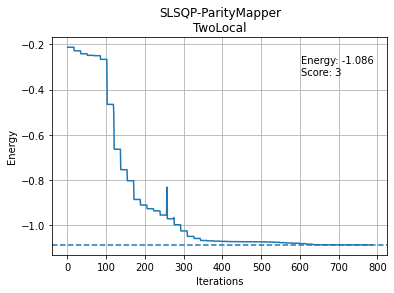

In [8]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_thresholdaccuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2_final.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

In [9]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



In [185]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex5
submit_ex5(ansatz,qubit_op,result,freeze_core)

Submitting your answer for ex5. Please wait...
Success 🎉! Your answer has been submitted.
